### 1. Procesamiento y visualizacion de los datos

In [10]:
#Primero importamos las librerias necesarias
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed 
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Para reproducibilidad
np.random.seed(1)
tf.random.set_seed(1)

C:\Users\ricar\AppData\Local\Temp\ipykernel_20556\3511180871.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')


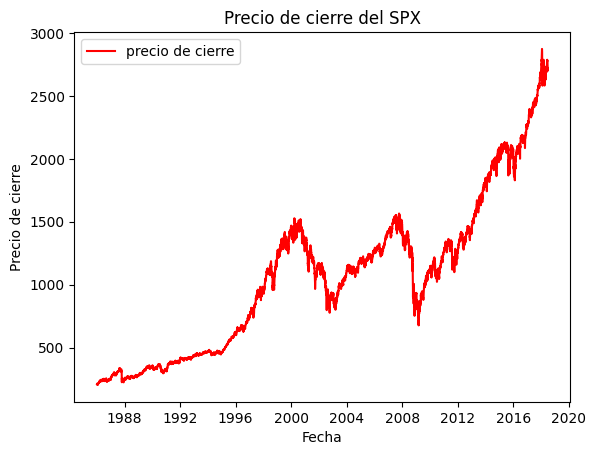

In [11]:
#Cargamos los datos 
data = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

# Realizamos una visualización de los datos
plt.plot(data, label = 'precio de cierre', color='red')
plt.title('Precio de cierre del SPX')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre')
plt.legend()

Para los datos de entrenamiento y los datos de prueba se usara 90% y 10% respectivamente

In [12]:
# Separamos los datos en entrenamiento y prueba
train_data, test_data = train_test_split(data, test_size=0.1, shuffle=False)
print(train_data.shape, test_data.shape)

# Usamos un scaler para normalizar los datos
scaler = StandardScaler()
scaler = scaler.fit(train_data[['close']])
# Transformamos los datos de entrenamiento y prueba
train_data['close'] = scaler.transform(train_data[['close']]) 
test_data['close'] = scaler.transform(test_data[['close']])

(7372, 1) (820, 1)


### **Creación de Secuencias para Modelos de Series Temporales**

La función **`crear_secuencia`** permite transformar los datos en secuencias, donde cada secuencia contiene un número de pasos de tiempo (`time_steps`) y su correspondiente etiqueta (el siguiente valor en la serie temporal). Esta transformación es fundamental para entrenar modelos.

* **Entrenamiento y prueba**: Usamos **`crear_secuencia`** para generar secuencias para los conjuntos de entrenamiento y prueba, utilizando una ventana de 10 pasos de tiempo.
* **Reformateo para LSTM**: Las secuencias generadas se reestructuran en formato 3D, con dimensiones `(muestras, pasos de tiempo, características)`, que es el formato esperado por los modelos LSTM.
* **Verificación**: Se verifican las dimensiones de las secuencias generadas para asegurar que estén correctamente estructuradas antes de ser alimentadas al modelo.

Este proceso garantiza que los datos estén en el formato adecuado para entrenar modelos de series temporales.


In [13]:
def crear_secuencia(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Aplicamos la función crear_secuencia para generar secuencias de entrenamiento y prueba

# Definimos el número de pasos de tiempo
time_steps = 35

# Creamos las secuencias para el conjunto de entrenamiento
X_train, y_train = crear_secuencia(train_data[['close']], train_data.close, time_steps)
# Creamos las secuencias para el conjunto de prueba
X_test, y_test = crear_secuencia(test_data[['close']], test_data.close, time_steps)

# imprimimos las dimensiones de las secuencias generadas
print(X_train.shape)
print(X_test.shape)

(7337, 35, 1)
(785, 35, 1)


### Entrenamiento de un Autoencoder con Acumulación de Gradientes

Este código implementa un ciclo de entrenamiento para un **autoencoder** utilizando la técnica de **acumulación de gradientes**. El autoencoder está diseñado para aprender representaciones comprimidas de los datos, y se entrena para minimizar la diferencia entre las entradas y las salidas (reconstrucción). La acumulación de gradientes permite simular un tamaño de batch mayor sin sobrecargar la memoria.

1. **Configuración inicial**:
   Se definen varios parámetros de entrenamiento, como el tamaño del batch (**BATCH\_SIZE**), el número de pasos de acumulación de gradientes (**ACCUMULATION\_STEPS**), el número de épocas (**EPOCHS**), y la dimensión de codificación (**ENCODING\_DIM**).

2. **Modelo Autoencoder**:
   El modelo autoencoder consta de dos partes principales:

   * **Encoder**: Comprende capas densas que reducen progresivamente las dimensiones de la entrada hasta llegar a la dimensión de codificación (**ENCODING\_DIM**).
   * **Decoder**: Aumenta las dimensiones a través de capas densas hasta reconstruir la entrada original.

   El autoencoder se implementa como un modelo secuencial que primero pasa por el encoder y luego por el decoder.

3. **Optimizador y función de pérdida**:
   Se utiliza el optimizador **Adam** con una tasa de aprendizaje de 0.001 y la función de pérdida **Mean Squared Error (MSE)** para evaluar la diferencia entre la entrada original y la reconstrucción del autoencoder.

4. **Ciclo de entrenamiento con acumulación de gradientes**:
   El ciclo de entrenamiento se lleva a cabo en varias épocas. En cada época, los gradientes se acumulan durante varios mini-lotes antes de aplicarlos a los pesos del modelo:

   * Se inicializan los gradientes acumulados como variables que no son entrenables.
   * Para cada mini-lote, los gradientes se calculan y se acumulan.
   * Después de acumular los gradientes durante el número especificado de pasos de acumulación, los gradientes acumulados se aplican a los pesos del modelo.
   * Al finalizar cada época, se imprime la **pérdida promedio**.

5. **Preparación de los datos**:
   Los datos de entrada se **aplanan** para que puedan ser procesados por el modelo, dado que el autoencoder en este caso no está utilizando arquitectura convolucional ni secuencial, sino capas densas.

6. **Entrenamiento**:
   El modelo autoencoder se entrena con el conjunto de datos utilizando la función de entrenamiento con **acumulación de gradientes**. El entrenamiento se realiza durante el número de épocas especificado, y la pérdida se imprime al final de cada época.

Este enfoque es útil cuando se desea entrenar modelos con grandes conjuntos de datos sin sobrecargar la memoria, ya que permite simular un tamaño de batch más grande sin necesidad de cargar todos los datos en la memoria a la vez.


In [14]:
# Configuración para autoencoder
BATCH_SIZE = 64
ACCUMULATION_STEPS = 4
EPOCHS = 10
ENCODING_DIM = 16

# Modelo Autoencoder para datos de series temporales
def create_autoencoder(input_dim, encoding_dim=16):
    # Encoder
    encoder = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(encoding_dim, activation='relu')
    ])
    
    # Decoder
    decoder = Sequential([
        Dense(32, activation='relu', input_shape=(encoding_dim,)),
        Dense(64, activation='relu'),
        Dense(input_dim, activation='sigmoid')
    ])
    
    # Autoencoder completo
    autoencoder = Sequential([encoder, decoder])
    return autoencoder

# Optimizador y función de pérdida
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.MeanSquaredError()

# Ciclo de entrenamiento con acumulación de gradientes para autoencoder
def train_autoencoder_with_gradient_accumulation(model, train_dataset, epochs, batch_size, accumulation_steps):
    for epoch in range(epochs):
        epoch_loss = 0.0
        batch_count = 0
        
        # Inicializar gradientes acumulados
        accumulated_gradients = [tf.Variable(tf.zeros_like(var), trainable=False) 
                               for var in model.trainable_variables]
        
        for step, x_batch in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                # Para autoencoder, la entrada es también la salida objetivo
                reconstructed = model(x_batch, training=True)
                loss = loss_fn(x_batch, reconstructed)
                # Escalar pérdida por pasos de acumulación
                scaled_loss = loss / accumulation_steps
            
            # Calcular gradientes
            gradients = tape.gradient(scaled_loss, model.trainable_variables)
            
            # Acumular gradientes
            for i, grad in enumerate(gradients):
                accumulated_gradients[i].assign_add(grad)
            
            epoch_loss += loss
            batch_count += 1
            
            # Aplicar gradientes cada accumulation_steps
            if (step + 1) % accumulation_steps == 0:
                optimizer.apply_gradients(zip(accumulated_gradients, model.trainable_variables))
                
                # Reinicializar gradientes acumulados
                for acc_grad in accumulated_gradients:
                    acc_grad.assign(tf.zeros_like(acc_grad))
        
        # Aplicar gradientes restantes si no se completó un ciclo
        if batch_count % accumulation_steps != 0:
            optimizer.apply_gradients(zip(accumulated_gradients, model.trainable_variables))
        
        avg_loss = epoch_loss / batch_count
        print(f'Época {epoch + 1}/{epochs}, Pérdida MSE: {avg_loss:.6f}')

# Preparar datos para autoencoder (aplanar secuencias)
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Crear dataset para autoencoder
train_dataset_ae = tf.data.Dataset.from_tensor_slices(X_train_flat)
train_dataset_ae = train_dataset_ae.batch(BATCH_SIZE)

# Crear y entrenar autoencoder
autoencoder = create_autoencoder(input_dim=X_train_flat.shape[1], encoding_dim=ENCODING_DIM)

print('Iniciando entrenamiento del autoencoder con acumulación de gradientes...')
train_autoencoder_with_gradient_accumulation(autoencoder, train_dataset_ae, EPOCHS, BATCH_SIZE, ACCUMULATION_STEPS)


Iniciando entrenamiento del autoencoder con acumulación de gradientes...


c:\Users\ricar\OneDrive\Documents\GitHub\AutoVisionClust\venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Época 1/10, Pérdida MSE: 1.239920
Época 2/10, Pérdida MSE: 1.046936
Época 3/10, Pérdida MSE: 0.764573
Época 4/10, Pérdida MSE: 0.696724
Época 5/10, Pérdida MSE: 0.634328
Época 6/10, Pérdida MSE: 0.599744
Época 7/10, Pérdida MSE: 0.600601
Época 8/10, Pérdida MSE: 0.583876
Época 9/10, Pérdida MSE: 0.579982
Época 10/10, Pérdida MSE: 0.587789


In [26]:
# Generamos las predicciones del conjunto de entrenamiento
reconstructed_train = autoencoder.predict(X_train.reshape(X_train.shape[0], -1))

#Calculamos el error de reconstrucción
mse_loss_train = np.mean(np.power(X_train_flat - reconstructed_train, 2), axis=1)
print('MSE Loss Train:', np.mean(mse_loss_train))

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step
MSE Loss Train: 0.569963321624152


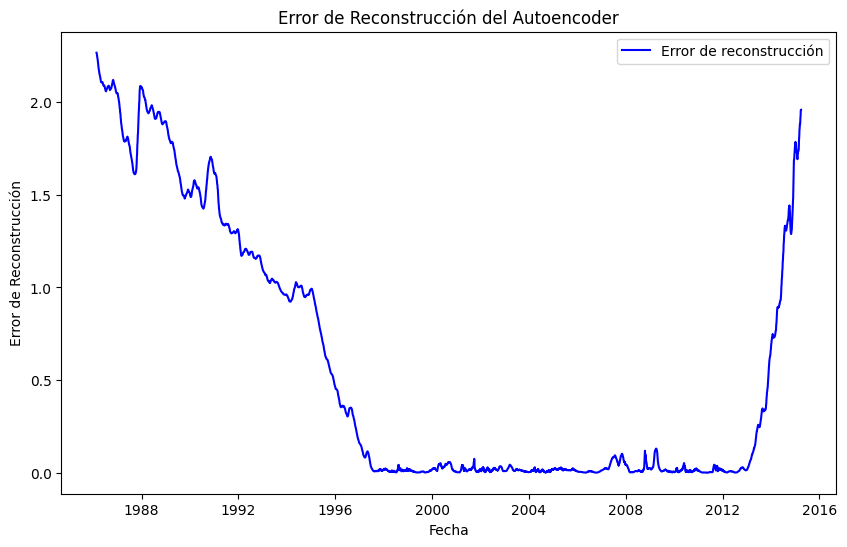

In [27]:
# Visualizamos el error de reconstrucción
plt.figure(figsize=(10, 6))
plt.plot(train_data.index[time_steps:], mse_loss_train, label='Error de reconstrucción', color='blue')
plt.title('Error de Reconstrucción del Autoencoder')
plt.xlabel('Fecha')
plt.ylabel('Error de Reconstrucción')
plt.legend()
plt.show()


In [21]:
print(f"Original X_train samples: {X_train.shape[0]}")
print(f"Reconstructed samples: {reconstructed.shape[0]}")


Original X_train samples: 7337
Reconstructed samples: 785


IndexError: index 3310 is out of bounds for axis 0 with size 785

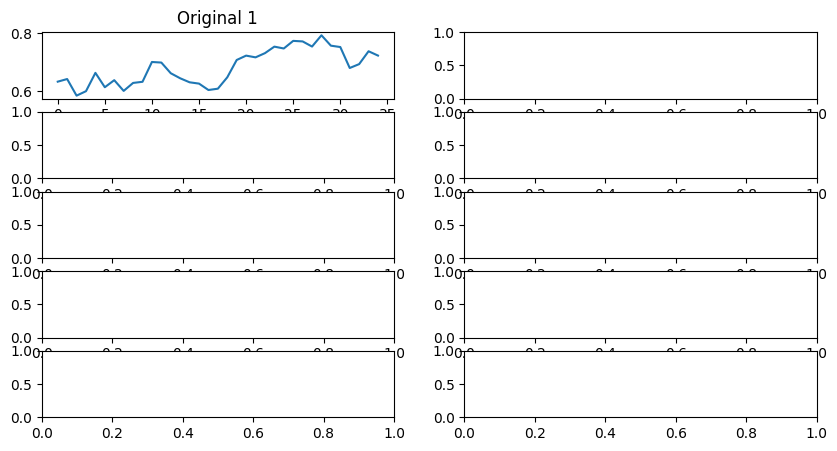

In [20]:
import matplotlib.pyplot as plt

# Seleccionar un subconjunto de las muestras para graficar
n_samples = 5  # Número de muestras a graficar
sample_idx = np.random.choice(len(X_train), n_samples, replace=False)

# Graficar las muestras originales y las reconstruidas
fig, axes = plt.subplots(n_samples, 2, figsize=(10, 5))

for i, idx in enumerate(sample_idx):
    # Entrada original (reshape a (35,) para visualización)
    axes[i, 0].plot(X_train[idx].reshape(35,), label='Original')
    axes[i, 0].set_title(f'Original {i+1}')
    
    # Reconstrucción (reshape a (35,) para visualización)
    axes[i, 1].plot(reconstructed[idx].reshape(35,), label='Reconstrucción')
    axes[i, 1].set_title(f'Reconstrucción {i+1}')
    
plt.tight_layout()
plt.show()
